## 10.5 Dynamic harmonic regression
When there are long seasonal periods, a dynamic regression with Fourier terms is often better than other models we have considered in this book.

For example, daily data can have annual seasonality of length 365, weekly data has seasonal period of approximately 52, while half-hourly data can have several seasonal periods, the shortest of which is the daily pattern of period 48.

Seasonal versions of ARIMA and ETS models are designed for shorter periods such as 12 for monthly data or 4 for quarterly data. For larger values of seasonal period $m$, the parameter estimation becomes almost impossible. For such time series, we prefer a harmonic regression approach where the seasonal pattern is modelled using Fourier terms with short-term time series dynamics handled by an ARMA error.

The advantages of this approach are:
- it allows any length seasonality;
- for data with more than one seasonal period, Fourier terms of different frequencies can be included;
- the smoothness of the seasonal pattern can be controlled by $K$, the number of Fourier sin and cos pairs – the seasonal pattern is smoother for smaller values of $K$;
- the short-term dynamics are easily handled with a simple ARMA error.

The only real disadvantage (compared to a seasonal ARIMA model) is that the seasonality is assumed to be fixed — the seasonal pattern is not allowed to change over time. But in practice, seasonality is usually remarkably constant so this is not a big disadvantage except for long time series.

### Example: Australian eating out expenditure
In this example we demonstrate combining Fourier terms for capturing seasonality with ARIMA errors capturing other dynamics in the data.

We use the total monthly expenditure on cafes, restaurants and takeaway food services in Australia (\$billion) from 2004 up to 2018 and forecast 24 months ahead. We vary $K$, the number of Fourier sin and cos pairs, from $K=1$ to $K=6$ (which is equivalent to including seasonal dummies). Note that as $K$ increases the Fourier terms capture and project a more 'wiggly' seasonal pattern and simpler ARIMA models are required to capture other dynamics. The AICc value is minimised for $K=6$, with a significant jump going from $K=4$ to $K=5$, hence we use this model to make forecasts.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
from utils import *

In [5]:
aus_cafe = (
    pd.read_csv("../data/tsibbledata/aus_retail.csv", parse_dates=["Month"])
    .query('Industry.str.contains("takeaway")')
    .query("Month.dt.year.between(2004, 2018)")
    .groupby("Month")
    .Turnover.sum()
    .pipe(set_freq)
)

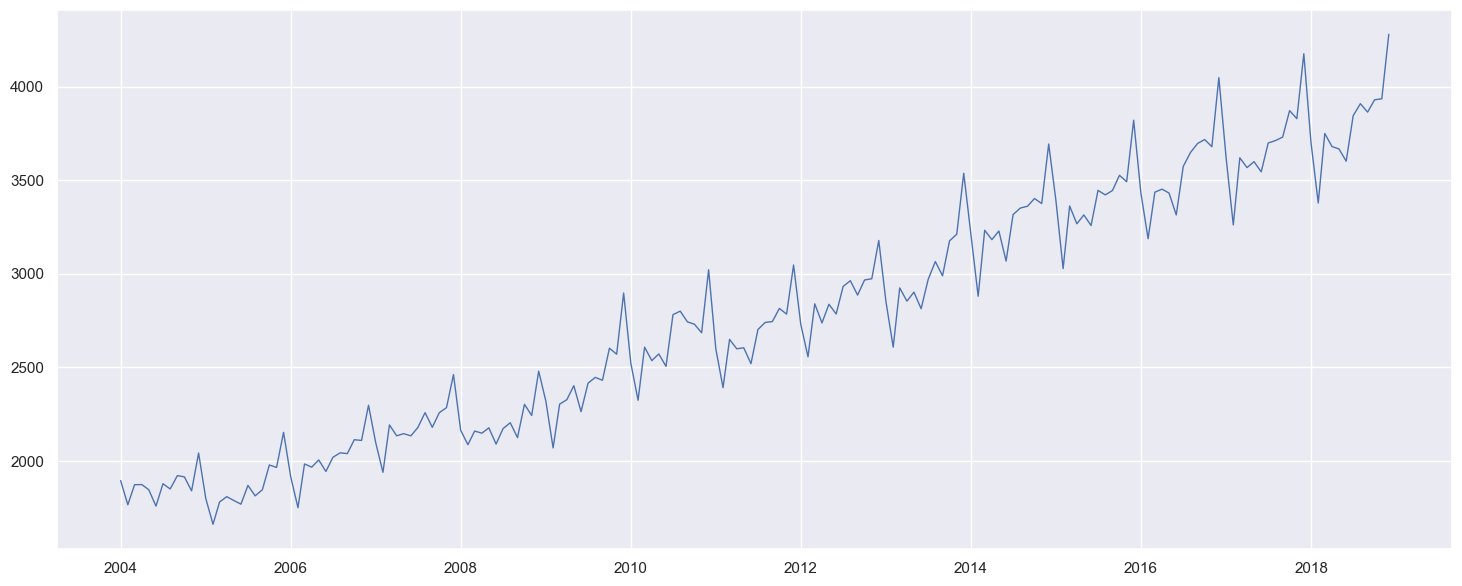

In [7]:
fig, ax = plt.subplots()
ax.plot(aus_cafe);

In [9]:
fits = {
    k: sm.tsa.UnobservedComponents(
        aus_cafe,
        level=True,
        trend=True,
        freq_seasonal=[{'period': 12, 'harmonics': k}]
    ).fit(disp=0)
    for k in range(1, 7)
}

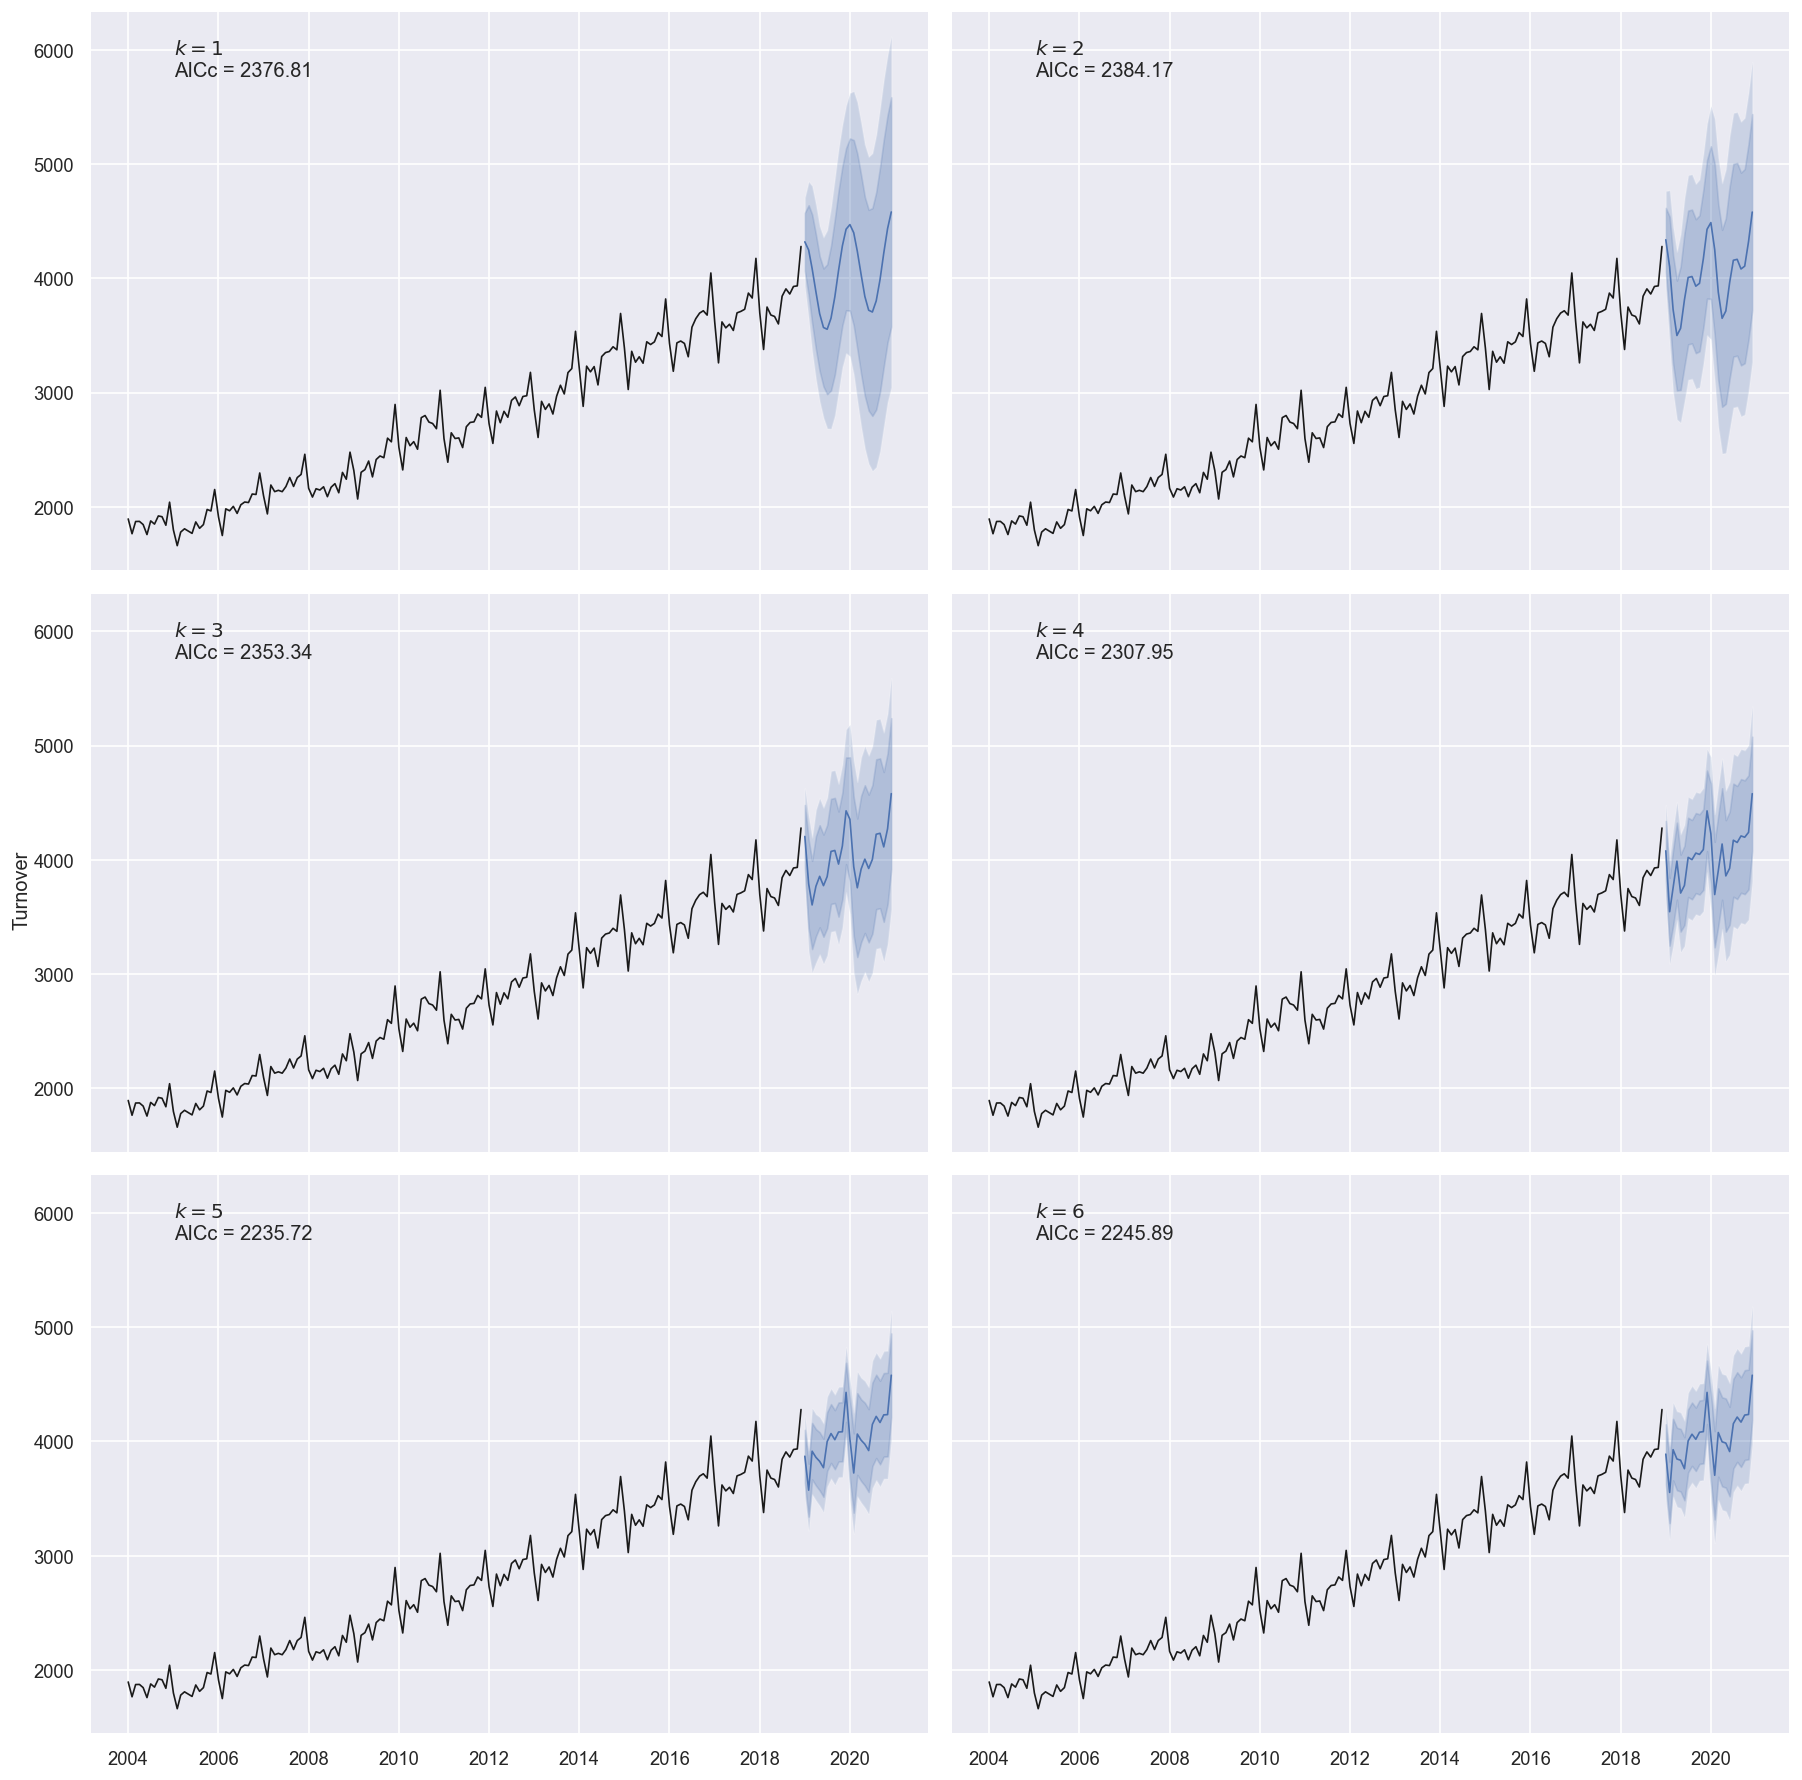

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(15,15), sharex=True, sharey=True, dpi=120)
axs = axs.ravel()
for (ax,(k,fit)) in zip(axs, fits.items()):
    ax.plot(aus_cafe, 'k')
    fc = fit.get_forecast(24)
    ax.plot(fc.predicted_mean)
    ci = ciclean(fc.conf_int())
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2)
    ci = ciclean(fc.conf_int(alpha=.2))
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2, color='C0')
    ax.text(.1, .95, f'$k={k}$\nAICc = {fit.aicc:.2f}', va='top', transform=ax.transAxes)
fig.text(0, .5, 'Turnover', rotation=90, va='center')
plt.tight_layout()
